# Import

In [1]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from tqdm import tqdm

# Defines

In [2]:
# Set start date for analysis
START_DATE = '2020-03-01'

In [3]:
# Make sure data files are correct
degiro_file = 'data/Transactions.csv'
## DO NOT FORGET TO REMOVE EXTRA TEXT IN COINBASE CSV
coinbase_file = 'data/Coinbase.csv'

In [4]:
# Dictionary with {'Degiro Asset Name':'Yahoo Finance ticker'}
ticker_symbols = {
    'INTEL CORPORATION - CO':'INTC',
    'JP MORGAN CHASE & CO.':'JPM',
    'ABBVIE INC. COMMON STO':'ABBV',
    'EDP':'EDP.LS',
    'FUT.CLUBE PORTO':'FCP.LS',
    'BTC':'BTC-EUR'
    }

In [5]:
# These attributes use portuguese data. Please change it if needed
degiro_variable_names_transformer = {
    'Data':'date', 
    'Produto':'ticker', 
    'Quantidade':'quantity', 
    'Unnamed: 6':'currency', 
    'Preços':'price', 
    'Taxa de Câmbio':'exchange_rate', 
    'Custos de':'fee'
    }

coinbase_variable_names_transformer = {
    'Asset':'ticker', 
    'Quantity Transacted':'quantity', 
    'EUR Spot Price at Transaction':'price', 
    'EUR Fees':'fee'
    }

In [6]:
# Empty list to save data frames for concatenation
exchanges = []

# Processing Degiro information
Create dataframe with the following information:
- date (of acquision)
- ticker (Yahoo Finance)
- quantity
- currency
- price
- exchange_rate
- fee
- exchange

In [7]:
# Load file and renaming variables of interest
degiro_df = pd.read_csv(degiro_file)[['Data', 'Produto', 'Quantidade', 'Unnamed: 6', 'Preços', 'Taxa de Câmbio', 'Custos de']]
degiro_df = degiro_df.rename(columns=degiro_variable_names_transformer)

# Format data
## Use pandas datetime format
degiro_df['date'] = pd.to_datetime(degiro_df['date'], dayfirst=True)
## Change all asset names to Yahoo Finance tickers
degiro_df['ticker'] = degiro_df['ticker'].replace(ticker_symbols)
## Transform fees into a positive number (consistency among exchanges)
degiro_df['fee'] *= -1
## Set exchange name
degiro_df['exchange'] = 'DEGIRO'

# Filter only required data
degiro_df = degiro_df[['date', 'ticker', 'quantity', 'currency', 'price', 'exchange_rate', 'fee', 'exchange']]

# Save dataframe pointer and display
exchanges.append(degiro_df)
degiro_df.head()

,date,ticker,quantity,currency,price,exchange_rate,fee,exchange
0,2020-11-25,INTC,5,USD,47.030,1.1908,0.52,DEGIRO
1,2020-11-25,JPM,4,USD,122.010,1.1908,0.51,DEGIRO
2,2020-09-03,ABBV,3,USD,93.950,1.1830,0.51,DEGIRO
3,2020-07-28,EDP.LS,18,EUR,4.375,NaN,0.54,DEGIRO
4,2020-07-01,FCP.LS,20,EUR,0.810,NaN,0.51,DEGIRO


# Processing Coinbase information
Create dataframe with the following information:
- date (of acquision)
- ticker (Yahoo Finance)
- quantity
- currency
- price
- exchange_rate
- fee
- exchange

In [8]:
# Load file and renaming variables of interest
coinbase_df = pd.read_csv(coinbase_file)
coinbase_df = coinbase_df.rename(columns={'Asset':'ticker', 'Quantity Transacted':'quantity', 'EUR Spot Price at Transaction':'price', 'EUR Fees':'fee'})

# Format data
## Change all asset names to Yahoo Finance tickers
coinbase_df['ticker'] = coinbase_df['ticker'].replace(ticker_symbols)
## Split data and transform in datetime variable
coinbase_df[['date', 'hour']] = coinbase_df['Timestamp'].str.split('T', expand=True)
coinbase_df['date'] = pd.to_datetime(coinbase_df['date'])
## Transform quantities to negative if action is sell
coinbase_df['quantity'] = coinbase_df['quantity'] * ((coinbase_df['Transaction Type'] == 'Buy') * 2 - 1)
## Manually add currency, exchange rate and exchange
coinbase_df['currency'] = 'EUR'
coinbase_df['exchange_rate'] = 1
coinbase_df['exchange'] = 'COINBASE'

# Filter only required data
coinbase_df = coinbase_df[['date', 'ticker', 'quantity', 'currency', 'price', 'exchange_rate', 'fee', 'exchange']]

# Save dataframe pointer and display
exchanges.append(coinbase_df)
coinbase_df.head()

,date,ticker,quantity,currency,price,exchange_rate,fee,exchange
0,2020-03-30,BTC-EUR,0.03364,EUR,5717.26,1,7.67,COINBASE


# Merging data

In [9]:
# Merge data from all exchanges
portfolio = pd.concat(exchanges).sort_values('date')

# Set date as index
portfolio = portfolio.set_index('date')

# Fill NaN data points
portfolio.fee = portfolio.fee.fillna(0)
portfolio.exchange_rate = portfolio.exchange_rate.fillna(1)

# Calculate relevant metrics
## Total money spent acquiring asset
portfolio['investiment'] = portfolio.quantity * portfolio.price / portfolio.exchange_rate + portfolio.fee
## Total value of acquired assets (cumulative over time)
portfolio['total_investment'] = (portfolio.quantity * portfolio.price / portfolio.exchange_rate).cumsum()
## Total fees paid acquiring assets (cumulative over time)
portfolio['total_fee'] = portfolio.fee.cumsum()
## Total money spent acquiring assets (cumulative over time)
portfolio['total_investment_cost'] = portfolio.total_fee + portfolio.total_investment

# Display data
portfolio.tail()

,ticker,quantity,currency,price,exchange_rate,fee,exchange,investiment,total_investment,total_fee,total_investment_cost
date,,,,,,,,,,,
2020-07-01,FCP.LS,20.0,EUR,0.810,1.0000,0.51,DEGIRO,16.710000,208.529884,8.18,216.709884
2020-07-28,EDP.LS,18.0,EUR,4.375,1.0000,0.54,DEGIRO,79.290000,287.279884,8.72,295.999884
2020-09-03,ABBV,3.0,USD,93.950,1.1830,0.51,DEGIRO,238.760211,525.530096,9.23,534.760096
2020-11-25,INTC,5.0,USD,47.030,1.1908,0.52,DEGIRO,197.992288,723.002383,9.75,732.752383
2020-11-25,JPM,4.0,USD,122.010,1.1908,0.51,DEGIRO,410.352123,1132.844506,10.26,1143.104506


# Calculating features for visualization

In [10]:
# Initialize data frames to save information
positions = pd.DataFrame(index = pd.date_range(start=START_DATE, end=pd.to_datetime('today')))
dividends = pd.DataFrame(index = pd.date_range(start=START_DATE, end=pd.to_datetime('today')))
positions_fixed_rate = pd.DataFrame(index = pd.date_range(start=START_DATE, end=pd.to_datetime('today')))

# Add ForEx rate to the tables that require that information
## Get ForEx data
forex_rate_EUR_USD = yf.Ticker('EURUSD=X').history(period="max").rename(columns={'Close':'forex_EURUSD'})
## Join ForEx data to data frames
positions = positions.join(forex_rate_EUR_USD['forex_EURUSD'])
dividends = dividends.join(forex_rate_EUR_USD['forex_EURUSD'])

In [11]:
# Doing the same process for every ticker in the portfolio
for ticker in tqdm(portfolio.ticker.unique()):
    # Download data from Yahoo Finance
    yahoo_data = yf.Ticker(ticker)
    hist = yahoo_data.history(period="max")

    # Join information about purchases from portfolio
    hist = hist.join(portfolio[portfolio.ticker == ticker][['quantity', 'currency', 'exchange_rate']])
    hist.quantity = hist.quantity.fillna(0)
    hist.exchange_rate = hist.exchange_rate.fillna(1)

    # Calculate variables
    ## Cumulative position size
    hist['position_size'] = hist.quantity.cumsum()
    ## Position value over time
    hist[ticker] = hist.position_size * hist.Close
    ## Dividends received
    hist[ticker + '_div'] = hist.position_size * hist.Dividends

    # Add information to the data frames
    positions = positions.join(hist[ticker])
    dividends = dividends.join(hist[ticker + '_div'])

    # If currency of asset is USD, use ForEx data to calculate real returns
    if 'USD' in hist.currency.unique():
        positions[ticker] /= positions.forex_EURUSD
        dividends[ticker + '_div'] /= dividends.forex_EURUSD

    # Calculate portfolio excluding ForEx effect
    ## Create a fixed discount when purchases are made
    hist.quantity = hist.quantity/hist.exchange_rate
    ## Calculate returns as normal
    hist['position_size_fixed_rate'] = hist.quantity.cumsum()
    hist[ticker] = hist.position_size_fixed_rate * hist.Close

    # Add information to the data frame
    positions_fixed_rate = positions_fixed_rate.join(hist[ticker])

100%|██████████| 6/6 [00:02<00:00,  2.15it/s]


In [12]:
# Fill non-business days with data from previous day
positions = positions.fillna(method='ffill')

# Calculate value of all assets
positions['total_current_value'] = positions.drop('forex_EURUSD', axis = 1).sum(axis = 1)

# Display data frame
positions.tail()

,forex_EURUSD,BTC-EUR,FCP.LS,EDP.LS,ABBV,INTC,JPM,total_current_value
2020-12-31,1.229990,798.677233,14.6,92.808002,261.343667,202.522028,413.239249,1783.190181
2021-01-01,1.218027,812.934642,14.6,92.808002,261.343667,202.522028,413.239249,1797.447589
2021-01-02,1.218027,890.621211,14.6,92.808002,261.343667,202.522028,413.239249,1875.134158
2021-01-03,1.218027,900.236532,14.6,92.808002,261.343667,202.522028,413.239249,1884.749479
2021-01-04,1.225190,856.699714,14.5,96.696004,255.854205,203.152172,410.581248,1837.483343


In [13]:
# Fill NaN values with 0 for dividends
dividends = dividends.fillna(0)

# Remove unecessary data
dividends = dividends.drop('forex_EURUSD', axis = 1)
dividends = dividends[(dividends != 0).any(axis = 1)]

# Calculate total returns
dividends['total_dividends'] = dividends.sum(axis = 1)

# Display
dividends.tail()

,BTC-EUR_div,FCP.LS_div,EDP.LS_div,ABBV_div,INTC_div,JPM_div,total_dividends
2020-10-14,0.0,0.0,0.0,3.01477,0.0,0.0,3.01477


In [14]:
# Repeat 'positions' process
positions_fixed_rate = positions_fixed_rate.fillna(method='ffill')
positions_fixed_rate['total_current_value'] = positions_fixed_rate.sum(axis = 1)
positions_fixed_rate.tail()

,BTC-EUR,FCP.LS,EDP.LS,ABBV,INTC,JPM,total_current_value
2020-12-31,798.677233,14.6,92.808002,271.724433,209.187100,426.839099,1813.835868
2021-01-01,812.934642,14.6,92.808002,271.724433,209.187100,426.839099,1828.093277
2021-01-02,890.621211,14.6,92.808002,271.724433,209.187100,426.839099,1905.779846
2021-01-03,900.236532,14.6,92.808002,271.724433,209.187100,426.839099,1915.395167
2021-01-04,856.699714,14.5,96.696004,264.978862,209.019142,422.438704,1864.332426


# Calculating equivalent return of investing in the SP500

In [15]:
# Download data from Yahoo Finance
sp500_equivalent = yf.Ticker('^GSPC').history(start=START_DATE, end='2050-04-30').rename(columns={'Close':'SP500'})

# Get total investment value from portfolio
sp500_equivalent = sp500_equivalent.join(portfolio[['investiment']])
# Add ForEx value to the portfolio
sp500_equivalent = sp500_equivalent.join(forex_rate_EUR_USD[['forex_EURUSD']])

# Fill NaN values from days without purchases with 0s
sp500_equivalent.investiment = sp500_equivalent.investiment.fillna(0)

# Calculate
## Amount of potential purchase at the time
sp500_equivalent['quantity'] = sp500_equivalent.investiment * sp500_equivalent.forex_EURUSD / sp500_equivalent.SP500
## Cumulative sum of positions over time
sp500_equivalent['position_size'] = sp500_equivalent.quantity.cumsum()
## Value of position over time
sp500_equivalent['position_value'] = sp500_equivalent.position_size * sp500_equivalent.SP500 / sp500_equivalent.forex_EURUSD
## Value of dividends over time
sp500_equivalent['position_dividends'] = sp500_equivalent.position_size * sp500_equivalent.Dividends / sp500_equivalent.forex_EURUSD

# Display
sp500_equivalent

,Open,High,Low,SP500,Volume,Dividends,Stock Splits,investiment,forex_EURUSD,quantity,position_size,position_value,position_dividends
2020-03-02,2974.280029,3090.959961,2945.189941,3090.229980,6376400000,0,0,0.0,1.105131,0.0,0.000000,0.000000,0.0
2020-03-03,3096.459961,3136.719971,2976.629883,3003.370117,6355940000,0,0,0.0,1.114405,0.0,0.000000,0.000000,0.0
2020-03-04,3045.750000,3130.969971,3034.379883,3130.120117,5035480000,0,0,0.0,1.118068,0.0,0.000000,0.000000,0.0
2020-03-05,3075.699951,3083.040039,2999.830078,3023.939941,5575550000,0,0,0.0,1.113908,0.0,0.000000,0.000000,0.0
2020-03-06,2954.199951,2985.929932,2901.540039,2972.370117,6552140000,0,0,0.0,1.122385,0.0,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-28,3723.030029,3740.510010,3723.030029,3735.360107,3527460000,0,0,0.0,1.220510,0.0,0.401165,1227.761342,0.0
2020-12-29,3750.010010,3756.120117,3723.310059,3727.040039,3387030000,0,0,0.0,1.222345,0.0,0.401165,1223.187636,0.0
2020-12-30,3736.189941,3744.629883,3730.209961,3732.040039,3145200000,0,0,0.0,1.225295,0.0,0.401165,1221.879174,0.0
2020-12-31,3733.270020,3760.199951,3726.879883,3756.070068,3172510000,0,0,0.0,1.229990,0.0,0.401165,1225.053011,0.0


# Visualization

In [16]:
# Parameters used
plt.rcParams['figure.dpi'] = 500
plt.rcParams['figure.figsize'] = (24,13.5)
plt.rcParams['font.family'] = 'monospace'

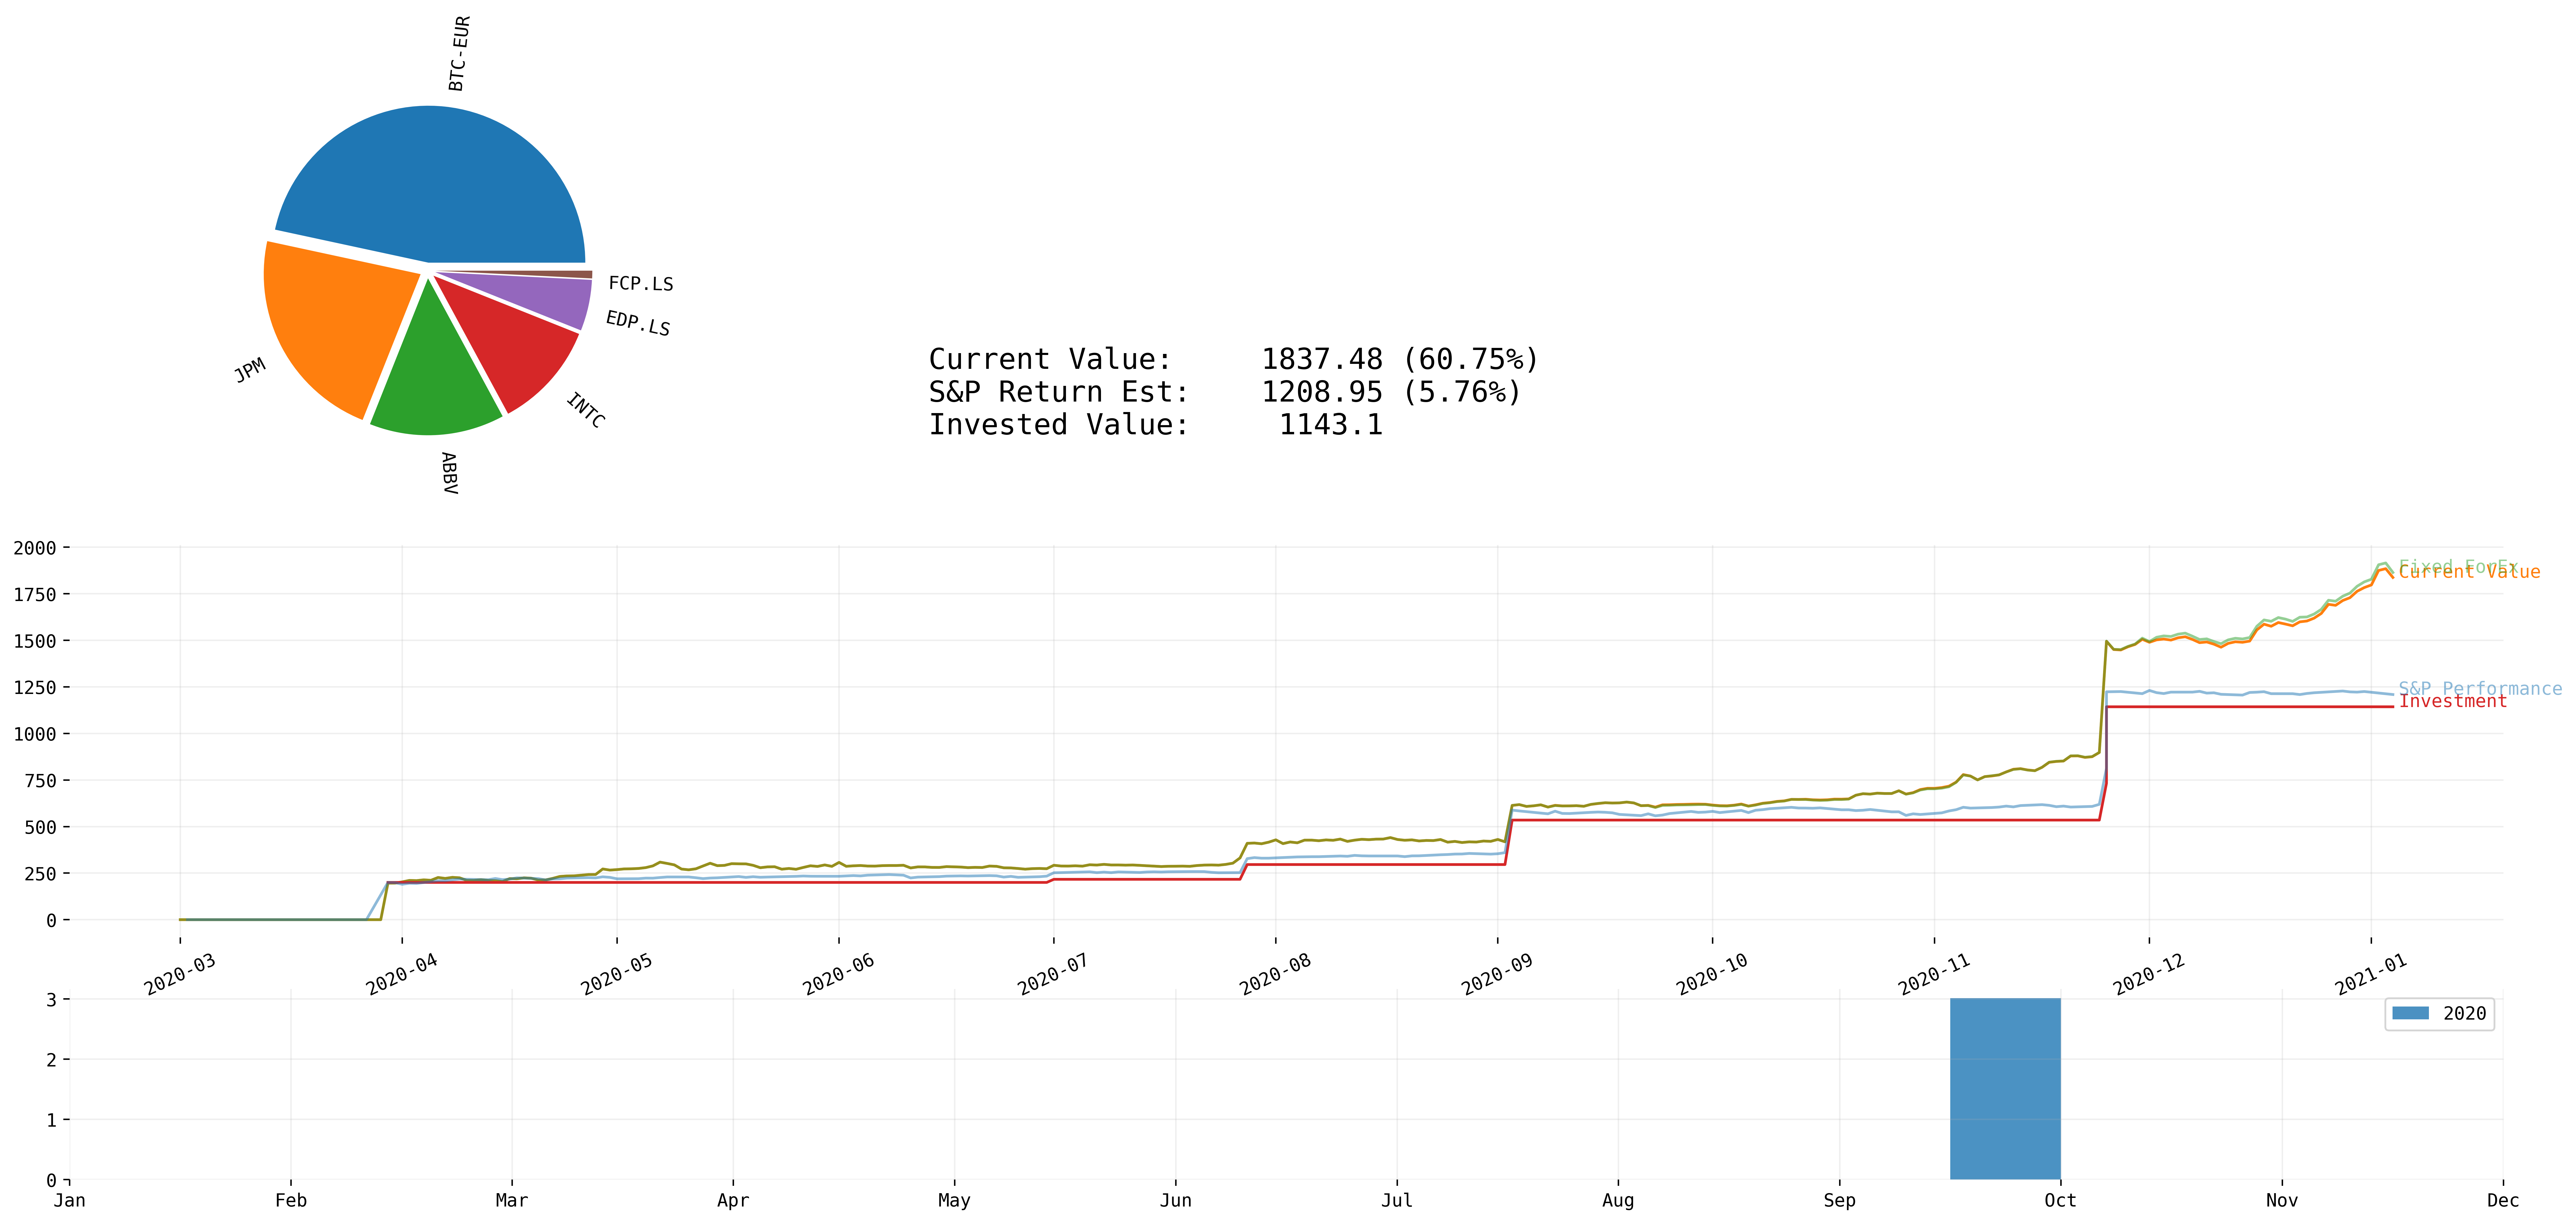

In [17]:
# First plot: Show a pie chart of the portfolio
plt.subplot(3,3,1)
## Get all individual positions
individual_positions = positions.drop(['forex_EURUSD', 'total_current_value'], axis = 1).iloc[-1].sort_values(ascending=False)
## Remove positions closed
individual_positions = individual_positions[individual_positions > 0]
## Plot pie chart
plt.pie(individual_positions, labels = individual_positions.index, rotatelabels = True, explode = [0.05 for _ in range(len(individual_positions.index))])

# Second plot: Print text information about the portfolio
plt.subplot(3,3,2)
## Remove axis and graphical noise 
plt.box(False)
plt.xticks([])
plt.yticks([])
## Define string to print
string_to_print = 'Current Value: '.ljust(16) + str(positions['total_current_value'][-1].round(2)).rjust(10) + ' (' + str(((positions['total_current_value'][-1]/portfolio['total_investment_cost'][-1] - 1)*100).round(2)) + '%)\n'
string_to_print += 'S&P Return Est: '.ljust(16) + str(sp500_equivalent['position_value'][-1].round(2)).rjust(10) + ' (' + str(((sp500_equivalent['position_value'][-1]/portfolio['total_investment_cost'][-1] - 1)*100).round(2)) + '%)\n'
string_to_print += 'Invested Value: '.ljust(16) + str(portfolio['total_investment_cost'][-1].round(2)).rjust(10) + '\n'
## Print string
plt.text(0, 0, string_to_print, fontsize=16)

# Third plot: show portfolio value over time
plt.subplot(3,1,2)
## Clean plot (aesthetic)
plt.box(False)
plt.grid(axis = 'both', alpha = 0.2)
## Plot current value, print text with actual value at the end
plt.plot(positions['total_current_value'], color = 'C1')
plt.text(pd.to_datetime('today'), positions['total_current_value'][-1], 'Current Value', color = 'C1')
## Plot current value at fixed ForEx
plt.plot(positions_fixed_rate['total_current_value'], color = 'C2', alpha = 0.5)
plt.text(pd.to_datetime('today'), positions_fixed_rate['total_current_value'][-1], 'Fixed ForEx', color = 'C2', alpha = 0.5)
## Plot total investment made
to_plot = pd.DataFrame(index = pd.date_range(start='2019-01-02', end=pd.to_datetime('today'))).join(portfolio['total_investment_cost']).fillna(method='ffill')['total_investment_cost']
plt.plot(to_plot, color = 'C3')
plt.text(pd.to_datetime('today'), to_plot[-1], 'Investment', color = 'C3')
## Plot SP500 equivalent returns
plt.plot(sp500_equivalent['position_value'], color = 'C0', alpha = 0.5)
plt.text(pd.to_datetime('today'), sp500_equivalent['position_value'][-1], 'S&P Performance', color = 'C0', alpha = 0.5)
## Rotate x axis text for easier readability
plt.xticks(rotation=25)


# Forth plot: Show dividend growth over time
plt.subplot(6,1,5)
## Clean plot (aesthetic)
plt.box(False)
plt.grid(axis = 'both', alpha = 0.2)
## Group dividends by month and year
grouped_dividends = dividends.groupby(by=[dividends.index.month, dividends.index.year]).sum().reset_index(level=[0,1])
## Iterate through all available years
years_available = grouped_dividends.level_1.unique()
for i, level in enumerate(years_available):
    ## Plot a bar with the corresponding monthly dividends, reducing bar width when more years are available
    temp_df = grouped_dividends[grouped_dividends.level_1 == level]
    plt.bar(temp_df.level_0 + i/(len(years_available)+1) - len(years_available)/2/(len(years_available)+1), temp_df['total_dividends'], width = 1/(len(years_available)+1), label = level, alpha = 0.8)
## Add information and change ticks to name of the month
plt.legend()
plt.xticks([i for i in range(1,13)], ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']);

# Save figure
plt.savefig('report.png')